# Imports

In [32]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


# df

In [33]:
base_dir = Path.cwd().parent
model_path = os.path.join(base_dir, "CE263N Assignment 4", "train.csv")
TRAIN_CSV_PATH = model_path
df = pd.read_csv(TRAIN_CSV_PATH)
df

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0
2,2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,2620.0
3,3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0
4,4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,582.0
...,...,...,...,...,...,...,...
145996,145996,-74.017975,40.706478,-74.002213,40.686069,2015-05-27 23:38:58,713.0
145997,145997,-73.968781,40.757835,-73.951843,40.769596,2015-01-07 02:58:34,308.0
145998,145998,-74.005699,40.740265,-73.982620,40.777214,2015-09-07 00:17:32,677.0
145999,145999,-73.972466,40.754219,-73.974335,40.759819,2015-11-09 15:13:00,435.0


# Features

## Coordinates

In [11]:
def fix_coordinates(df):
        df_fixed = df.copy()
        
        suspicious_start = df_fixed['start_lng'] > 0
        suspicious_end = df_fixed['end_lng'] > 0
                
        df_fixed.loc[suspicious_start, 'start_lng'] = -df_fixed.loc[suspicious_start, 'start_lng']
        df_fixed.loc[suspicious_end, 'end_lng'] = -df_fixed.loc[suspicious_end, 'end_lng']
        
        return df_fixed

In [12]:
df_fixed_test = df.copy()
suspicious_start = df_fixed_test['start_lng'] > 0
suspicious_end = df_fixed_test['end_lng'] > 0
print(suspicious_start.sum(), suspicious_end.sum())
df_fixed_test = fix_coordinates(df_fixed_test)
suspicious_start = df_fixed_test['start_lng'] > 0
suspicious_end = df_fixed_test['end_lng'] > 0
print(suspicious_start.sum(), suspicious_end.sum())

1000 0
0 0


## Distance

In [13]:
def calculate_distance(df):
        EARTH_RADIUS_KM = 6371.0
        df_dist = df.copy()
        
        lat1 = np.radians(df_dist['start_lat'])
        lon1 = np.radians(df_dist['start_lng'])
        lat2 = np.radians(df_dist['end_lat'])
        lon2 = np.radians(df_dist['end_lng'])
        
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        
        df_dist['distance_km'] = c * EARTH_RADIUS_KM
        
        return df_dist

In [14]:
distance_df_test = df.copy()
distance_df_test = calculate_distance(distance_df_test)
print(distance_df_test['distance_km'].mean())
distance_df_test

109.25315651127492


,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration,distance_km
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0,15.760961
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0,2.535404
2,2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,2620.0,9.753753
3,3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0,1.168773
4,4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,582.0,1.944774
...,...,...,...,...,...,...,...,...
145996,145996,-74.017975,40.706478,-74.002213,40.686069,2015-05-27 23:38:58,713.0,2.629799
145997,145997,-73.968781,40.757835,-73.951843,40.769596,2015-01-07 02:58:34,308.0,1.935252
145998,145998,-74.005699,40.740265,-73.982620,40.777214,2015-09-07 00:17:32,677.0,4.545184
145999,145999,-73.972466,40.754219,-73.974335,40.759819,2015-11-09 15:13:00,435.0,0.642283


## Cluestering

In [15]:
def cluster_data(df, n_clusters=3):
        df_clustered = df.copy()
        kmeans = KMeans(n_clusters=n_clusters, random_state=95)
        
        coordinates = df_clustered[['start_lat', 'start_lng']].values
        df_clustered['start_cluster'] = kmeans.fit_predict(coordinates)
        
        end_kmeans = KMeans(n_clusters=n_clusters, random_state=95)
        coordinates = df_clustered[['end_lat', 'end_lng']].values
        df_clustered['end_cluster'] = end_kmeans.fit_predict(coordinates)
                
        return df_clustered

In [16]:
cluster_df_test = df.copy()
cluster_df_test.dropna(inplace=True)
cluster_df_test = cluster_data(cluster_df_test, n_clusters=3)
print(cluster_df_test['start_cluster'].value_counts())

start_cluster
1    104000
0     40001
2      1000
Name: count, dtype: int64


In [17]:
cluster_df_test = df.copy()
cluster_df_test.dropna(inplace=True)
cluster_df_test = cluster_data(cluster_df_test, n_clusters=3)
print(cluster_df_test['end_cluster'].value_counts())

end_cluster
1    102500
0     40001
2      2500
Name: count, dtype: int64


## Outliers per cluster

In [18]:
def remove_outliers(df, outlier_col, cluster_col='distance_km'):

    result = df.copy()
    
    for cluster in df[cluster_col].unique():
        cluster_data = df[df[cluster_col] == cluster][outlier_col]
        
        Q1, Q3 = cluster_data.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        
        valid_mask = (df[cluster_col] != cluster) | (
            (df[outlier_col] >= Q1 - 1.5 * IQR) & 
            (df[outlier_col] <= Q3 + 1.5 * IQR)
        )
        result = result[valid_mask]
    
    return result

In [19]:
outlier_df_test = df.copy()
outlier_df_test.dropna(inplace=True)
outlier_df_test = fix_coordinates(outlier_df_test)
outlier_df_test = calculate_distance(outlier_df_test)
outlier_df_test = cluster_data(outlier_df_test, n_clusters=3)

C:\Users\Theo\AppData\Local\Temp\ipykernel_16336\3472052987.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = result[valid_mask]
C:\Users\Theo\AppData\Local\Temp\ipykernel_16336\3472052987.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = result[valid_mask]


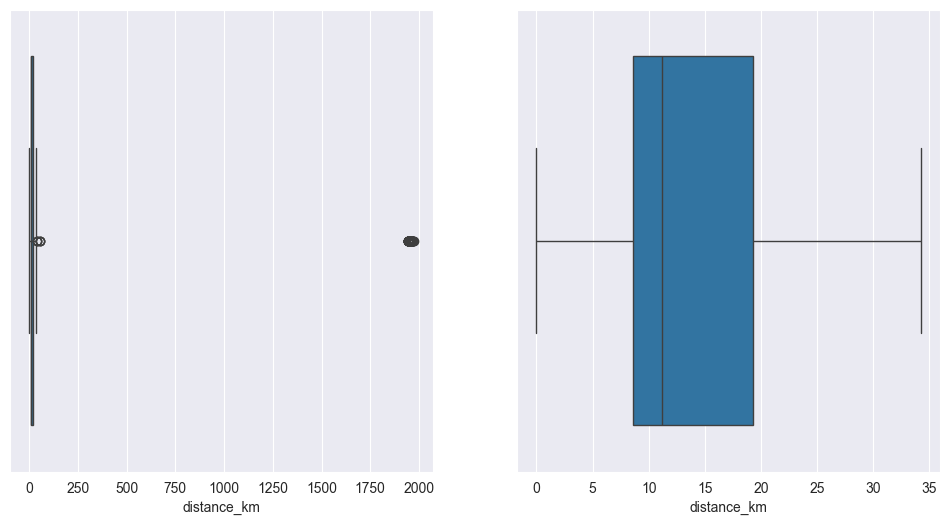

C:\Users\Theo\AppData\Local\Temp\ipykernel_16336\3472052987.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = result[valid_mask]


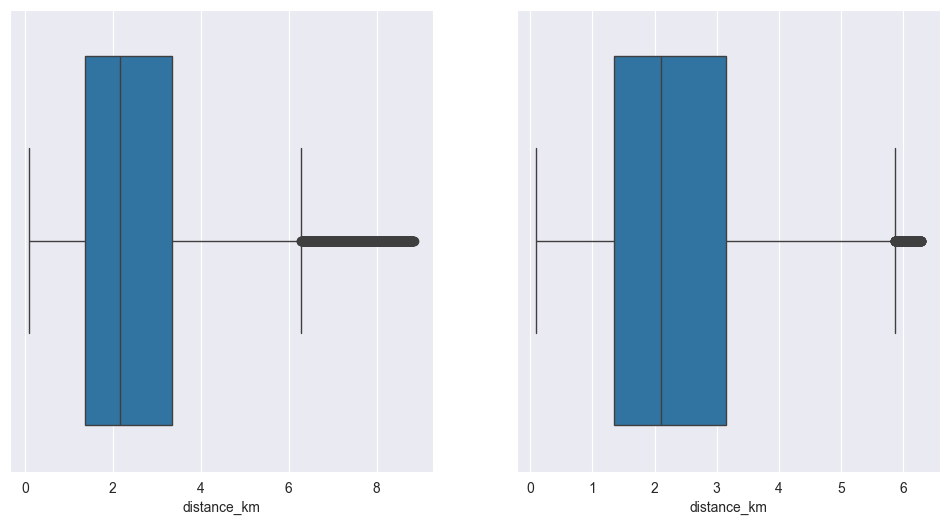

C:\Users\Theo\AppData\Local\Temp\ipykernel_16336\3472052987.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = result[valid_mask]


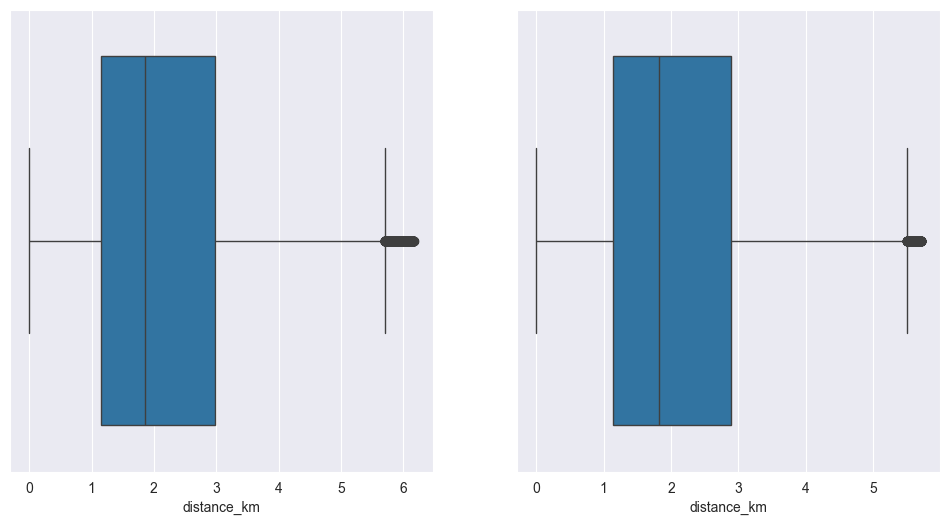

In [20]:
for cluster in outlier_df_test['start_cluster'].unique():
    _, axes = plt.subplots(1, 2, figsize=(12, 6))
    sns.boxplot(x=outlier_df_test[outlier_df_test['start_cluster'] == cluster]['distance_km'], ax=axes[0])
    outlier_df_test = remove_outliers(outlier_df_test, 'distance_km', cluster_col='start_cluster')
    sns.boxplot(x=outlier_df_test[outlier_df_test['start_cluster'] == cluster]['distance_km'], ax=axes[1])
    plt.show()

## Time features

In [21]:
def add_time_features(df, rush_hours=True):
    time_df = df.copy()
    time_df['datetime'] = pd.to_datetime(time_df['datetime'])
    time_df['hour'] = time_df['datetime'].dt.hour
    time_df['day_of_week'] = time_df['datetime'].dt.dayofweek
    time_df['month'] = time_df['datetime'].dt.month
    time_df['is_weekend'] = (time_df['day_of_week'] >= 5).astype(int)
    
    if rush_hours:
        time_df['is_morning_rush'] = ((time_df['hour'] >= 7) & (time_df['hour'] <= 9)).astype(int)
        time_df['is_evening_rush'] = ((time_df['hour'] >= 17) & (time_df['hour'] <= 19)).astype(int)
        time_df['is_rush_hour'] = (time_df['is_morning_rush'] | time_df['is_evening_rush']).astype(int)
    
    return time_df

In [22]:
df_features_time = df.copy()
df_features_time = add_time_features(df_features_time, rush_hours=True)
df_features_time

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration,hour,day_of_week,month,is_weekend,is_morning_rush,is_evening_rush,is_rush_hour
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0,0,4,1,0,0,0,0
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0,1,4,9,0,0,0,0
2,2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,2620.0,20,6,4,1,0,0,0
3,3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0,23,0,9,0,0,0,0
4,4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,582.0,12,2,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145996,145996,-74.017975,40.706478,-74.002213,40.686069,2015-05-27 23:38:58,713.0,23,2,5,0,0,0,0
145997,145997,-73.968781,40.757835,-73.951843,40.769596,2015-01-07 02:58:34,308.0,2,2,1,0,0,0,0
145998,145998,-74.005699,40.740265,-73.982620,40.777214,2015-09-07 00:17:32,677.0,0,0,9,0,0,0,0
145999,145999,-73.972466,40.754219,-73.974335,40.759819,2015-11-09 15:13:00,435.0,15,0,11,0,0,0,0


## geo features

In [23]:
def add_geo_features(df):
    geo_df = df.copy()
    geo_df['lat_diff'] = geo_df['end_lat'] - geo_df['start_lat']
    geo_df['lng_diff'] = geo_df['end_lng'] - geo_df['start_lng']
    
    return geo_df

In [24]:
geo_df_test = df.copy()
geo_df_test = add_geo_features(geo_df_test)
geo_df_test

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration,lat_diff,lng_diff
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0,0.036602,-0.180520
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0,-0.022716,0.002495
2,2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,2620.0,-0.011700,-0.114784
3,3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0,0.007472,-0.009355
4,4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,582.0,0.017403,0.002296
...,...,...,...,...,...,...,...,...,...
145996,145996,-74.017975,40.706478,-74.002213,40.686069,2015-05-27 23:38:58,713.0,-0.020409,0.015762
145997,145997,-73.968781,40.757835,-73.951843,40.769596,2015-01-07 02:58:34,308.0,0.011761,0.016938
145998,145998,-74.005699,40.740265,-73.982620,40.777214,2015-09-07 00:17:32,677.0,0.036949,0.023079
145999,145999,-73.972466,40.754219,-73.974335,40.759819,2015-11-09 15:13:00,435.0,0.005600,-0.001869


## same cluster

In [25]:
def add_same_cluster_features(df):
    same_cluster_df = df.copy()
    same_cluster_df['is_same_cluster'] = (same_cluster_df['start_cluster'] == same_cluster_df['end_cluster']).astype(int)
    same_cluster_df['is_inter_cluster'] = (same_cluster_df['start_cluster'] != same_cluster_df['end_cluster']).astype(int)
    return same_cluster_df

In [26]:
same_cluster_df_test = df.copy()
same_cluster_df_test.dropna(inplace=True)
same_cluster_df_test = cluster_data(same_cluster_df_test)
test_dfsame_cluster_df_test = add_same_cluster_features(same_cluster_df_test)
same_cluster_df_test

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration,start_cluster,end_cluster
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0,1,1
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0,0,0
2,2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,2620.0,1,1
3,3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0,0,0
4,4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,582.0,1,1
...,...,...,...,...,...,...,...,...,...
145996,145996,-74.017975,40.706478,-74.002213,40.686069,2015-05-27 23:38:58,713.0,1,1
145997,145997,-73.968781,40.757835,-73.951843,40.769596,2015-01-07 02:58:34,308.0,1,1
145998,145998,-74.005699,40.740265,-73.982620,40.777214,2015-09-07 00:17:32,677.0,1,1
145999,145999,-73.972466,40.754219,-73.974335,40.759819,2015-11-09 15:13:00,435.0,1,1


## Impossible values

In [27]:
impossible_values_df = df.copy()
print(len(impossible_values_df))
impossible_values_df = impossible_values_df[impossible_values_df['duration'] > 0]
impossible_values_df = impossible_values_df[impossible_values_df['duration'] < 10800]
impossible_values_df

146001


,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0
2,2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,2620.0
3,3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0
4,4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,582.0
...,...,...,...,...,...,...,...
145996,145996,-74.017975,40.706478,-74.002213,40.686069,2015-05-27 23:38:58,713.0
145997,145997,-73.968781,40.757835,-73.951843,40.769596,2015-01-07 02:58:34,308.0
145998,145998,-74.005699,40.740265,-73.982620,40.777214,2015-09-07 00:17:32,677.0
145999,145999,-73.972466,40.754219,-73.974335,40.759819,2015-11-09 15:13:00,435.0


# Train

In [28]:
train_df = df.copy()
print(f"Início: {len(df)} linhas")
train_df = train_df.dropna()
print(f"Após dropna: {len(train_df)} linhas")
train_df = fix_coordinates(train_df)
print(f"Após fix_coordinates: {len(train_df)} linhas")
train_df = calculate_distance(train_df)
train_df = cluster_data(train_df, n_clusters=3)
train_df = add_time_features(train_df, rush_hours=True)
train_df = add_geo_features(train_df)
train_df = add_same_cluster_features(train_df)
print(f"Após feature_pipeline: {len(train_df)} linhas")
train_df = remove_outliers(train_df, 'distance_km', cluster_col='start_cluster')
print(f"Após remove_outliers start: {len(train_df)} linhas")
train_df = remove_outliers(train_df, 'distance_km', cluster_col='end_cluster')
print(f"Após remove_outliers end: {len(train_df)} linhas")
train_df = train_df[train_df['duration'] > 0]
print(f"Após duration > 0: {len(train_df)} linhas")
train_df = train_df[train_df['distance_km'] > 0]
print(f"Após distance_km > 0: {len(train_df)} linhas")
train_df = train_df[train_df['distance_km']/(impossible_values_df['duration']/60/60)<100]
print(f"Após speed filter: {len(train_df)} linhas")



train_df

Início: 146001 linhas
Após dropna: 145001 linhas
Após fix_coordinates: 145001 linhas
Após feature_pipeline: 145001 linhas
Após remove_outliers start: 130679 linhas
Após remove_outliers end: 123738 linhas
Após duration > 0: 123301 linhas
Após distance_km > 0: 122795 linhas
Após speed filter: 121903 linhas


C:\Users\Theo\AppData\Local\Temp\ipykernel_16336\3472052987.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = result[valid_mask]
C:\Users\Theo\AppData\Local\Temp\ipykernel_16336\3472052987.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = result[valid_mask]
C:\Users\Theo\AppData\Local\Temp\ipykernel_16336\3472052987.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = result[valid_mask]
C:\Users\Theo\AppData\Local\Temp\ipykernel_16336\966011517.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df = train_df[train_df['distance_km']/(impossible_values_df['duration']/60/60)<100]


,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration,distance_km,start_cluster,end_cluster,...,day_of_week,month,is_weekend,is_morning_rush,is_evening_rush,is_rush_hour,lat_diff,lng_diff,is_same_cluster,is_inter_cluster
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0,2.535404,0,0,...,4,9,0,0,0,0,-0.022716,0.002495,1,0
3,3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0,1.168773,0,0,...,0,9,0,0,0,0,0.007472,-0.009355,1,0
4,4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,582.0,1.944774,1,1,...,2,1,0,0,0,0,0.017403,0.002296,1,0
5,5,-73.980431,40.738529,-73.988319,40.734810,2015-03-28 04:46:01,165.0,0.782752,1,1,...,5,3,1,0,0,0,-0.003719,-0.007888,1,0
6,6,-122.422805,37.772178,-122.396112,37.757865,2012-09-07 23:58:00,720.0,2.835229,0,0,...,4,9,0,0,0,0,-0.014313,0.026693,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145996,145996,-74.017975,40.706478,-74.002213,40.686069,2015-05-27 23:38:58,713.0,2.629799,1,1,...,2,5,0,0,0,0,-0.020409,0.015762,1,0
145997,145997,-73.968781,40.757835,-73.951843,40.769596,2015-01-07 02:58:34,308.0,1.935252,1,1,...,2,1,0,0,0,0,0.011761,0.016938,1,0
145998,145998,-74.005699,40.740265,-73.982620,40.777214,2015-09-07 00:17:32,677.0,4.545184,1,1,...,0,9,0,0,0,0,0.036949,0.023079,1,0
145999,145999,-73.972466,40.754219,-73.974335,40.759819,2015-11-09 15:13:00,435.0,0.642283,1,1,...,0,11,0,0,0,0,0.005600,-0.001869,1,0


## Separe X y

In [29]:
target = 'duration'

drop_cols = ['row_id', 'datetime']

feature_cols = [col for col in train_df.columns if col not in drop_cols + [target]]
X = train_df[feature_cols]
y = train_df[target]

# Train test split

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=95)

In [32]:
model = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=95, n_jobs=-1)
model.fit(X_train, y_train)

KeyboardInterrupt: 

In [70]:
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print('RMSE:', mse**0.5)
print((mse**0.5)/df[target].mean())

RMSE: 271.80136536598314
0.25563925992066333


In [72]:
gb_model = GradientBoostingRegressor(n_estimators=200, max_depth=6, random_state=95)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_val)
gb_rmse = mean_squared_error(y_val, gb_pred) ** 0.5
print("Gradient Boosting RMSE:", gb_rmse)

Gradient Boosting RMSE: 267.21873168112955


In [73]:
rf_tuned = RandomForestRegressor(
    n_estimators=300,     
    max_depth=15,        
    min_samples_split=5, 
    min_samples_leaf=2,   
    random_state=95, 
    n_jobs=-1
)
rf_tuned.fit(X_train, y_train)
rf_tuned_pred = rf_tuned.predict(X_val)
rf_tuned_rmse = mean_squared_error(y_val, rf_tuned_pred) ** 0.5
print("Random Forest tunado RMSE:", rf_tuned_rmse)

Random Forest tunado RMSE: 273.7124098354763


In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [200, 300, 400],        
    'max_depth': [20, 25, None],            
    'min_samples_split': [2, 5]             
}

grid_search_rapido = GridSearchCV(
    estimator=RandomForestRegressor(random_state=95, n_jobs=-1),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search_rapido.fit(X_train, y_train)
print("Best ", grid_search_rapido.best_params_)

# Testar no validation set
best_pred_rapido = grid_search_rapido.best_estimator_.predict(X_val)
rmse_rapido = mean_squared_error(y_val, best_pred_rapido) ** 0.5
print(f"RMSE otimizado: {rmse_rapido:.2f}")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END max_depth=20, min_samples_split=2, n_estimators=200; total time= 2.7min
[CV] END max_depth=20, min_samples_split=2, n_estimators=400; total time= 6.0min


/Users/theocoelho/.virtualenvs/tcc-py311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time= 4.2min
[CV] END max_depth=20, min_samples_split=5, n_estimators=300; total time= 4.3min
[CV] END max_depth=25, min_samples_split=2, n_estimators=200; total time= 3.2min
[CV] END max_depth=25, min_samples_split=5, n_estimators=200; total time= 3.0min
[CV] END max_depth=25, min_samples_split=5, n_estimators=300; total time= 4.7min
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time= 5.2min
Best  {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 400}
RMSE otimizado: 270.31


In [30]:
X_train = X_train.sort_index(axis=1)
model = RandomForestRegressor(max_depth= None, min_samples_split= 5, n_estimators= 400)
model.fit(X_train, y_train)


,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [32]:
X_val = X_val.sort_index(axis=1)
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print('RMSE:', mse**0.5)
print((mse**0.5)/df[target].mean())

RMSE: 270.792871474897
0.2546907340307929


In [38]:
df.iloc[6]

row_id                         6
start_lng            -122.422805
start_lat              37.772178
end_lng              -122.396112
end_lat                37.757865
datetime     2012-09-07 23:58:00
duration                   720.0
Name: 6, dtype: object

In [33]:
import pickle

with open('ronsomForestRefressor.pkl', 'wb') as f:
    pickle.dump(model, f)